## Introduction to DistKP
This notebook provides a minimal implementation of DistKP.

We consider $n$ agents. 
For the sake of simplicity, we use as domain a unit hyperrectangle $\mathcal{P} = [0,1]^{s}$.

The algorithm has two tunable parameters:
1. &nbsp;$E$: &nbsp;&nbsp;&nbsp; the order of the Nystrom approximation. A higher value yelds more precision at the cost of increased memory and computation.
2. &nbsp;$\sigma_w$: &nbsp;&nbsp; encodes our prioir knowledge of how fast the function changes with time.

At intialization the algorithm samples $E$ representative points (the seed guarantees that the same points are used by every agent) and computes the matrices $\Lambda$ and $U_{11}$ that are going to be used to compute the features.
<br>
<br>
During online operations the agent:
1. Collects a noisy sample of the function. <br><br>
2. Performs a local update step with a standard Kalman Filter.<br><br>
3. Performs $SensingPeriod$ times:  <br><br>
    3.1. Communicates the quantities $L = P^{-1} \theta$, $\widetilde{P} = P^{-1}$ to the neighbours.   <br><br>
    3.2. Updates the local measures with the incoming information by applying a modified inverse variance weighting step.   
</par>

In [1]:
import numpy as np
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import numpy as np
import matplotlib.pyplot as plt

sigma_init = 10

class Agent:
    sigma_init = 1e5
    def __init__(self, s, E, k, sigma_v, sigma_w, n, init_pos, seed=42):
        self.E = E
        self.n = n
        self.s = s
        self.k = k
        self.R = sigma_v**2 * np.eye(1)
        self.Q = sigma_w**2 * np.eye(self.E)
        self.pos = init_pos

        # Estimate initialization
        self.theta = np.zeros((E,1))
        self.P = sigma_init**2 * np.eye(E)

        # Compute representative points
        np.random.seed(seed)
        self.repr_points = np.zeros((E,self.s))
        for i in range(self.s):
            self.repr_points[:,i] = np.random.uniform(low=0.0, high=1.0, size=(E))

        K = self.k(self.repr_points, self.repr_points)
        self.U_11, self.Lambda, _ = np.linalg.svd(K)

    def extract_features(self, x):
        if x.ndim < 2:
            x = x[:, np.newaxis]
        phi = np.linalg.inv(np.diag(self.Lambda))**0.5 @ self.U_11.T @ self.k(self.repr_points, x)
        return phi
        
    def local_update(self, x, y):
        # Project domain point onto feature space
        phi = self.extract_features(x)

        # Kalman Filter
        # Prediction
        self.theta = self.theta
        self.P = self.P + Q

        # Correction
        K = self.P @ phi @ mp.linalg.inv(phi.T @ self.P @ phi + self.R)
        self.theta = self.theta + K @ (y - phi.T @ self.theta)
        self.P = (np,eye((self.E,self.E)) - K @ phi.T) @ self.P

    def communicate(self):
        # Implements communication with neighbours
        L = self.P.inv() @ self.theta
        P_tilde = np.linalg.inv(self.P)
        return L, P_tilde

    def update_pos(self, pos):
        self.pos = pos

    def network_update(self, neighbours):
        # Implements distributed estimate fusion
        for neighbour in neighbours:
            L, P_tilde = neighbour.communicate()
            sum_L += L
            sum_P_tilde += P

        L = sum_L/len(neighbours)
        P_tilde = sum_P_tilde/len(neighbours)
        self.theta = np.linalg.inv(P_tilde) @ L
        self.P = self.n * np.linalg.inv(P_tilde)

    def predict(self, x):
        # Predict mean and variance at coordinate x
        pred = np.zeros(x.shape)
        phi = self.extract_features(x)
        pred[0,:] = self.theta.T @ phi
        pred[1,:] = np.diag(phi.T @ self.P @ phi)

        return pred


We showcase the algorithm on a simple synthetic function, using a swarm of 10 drones.

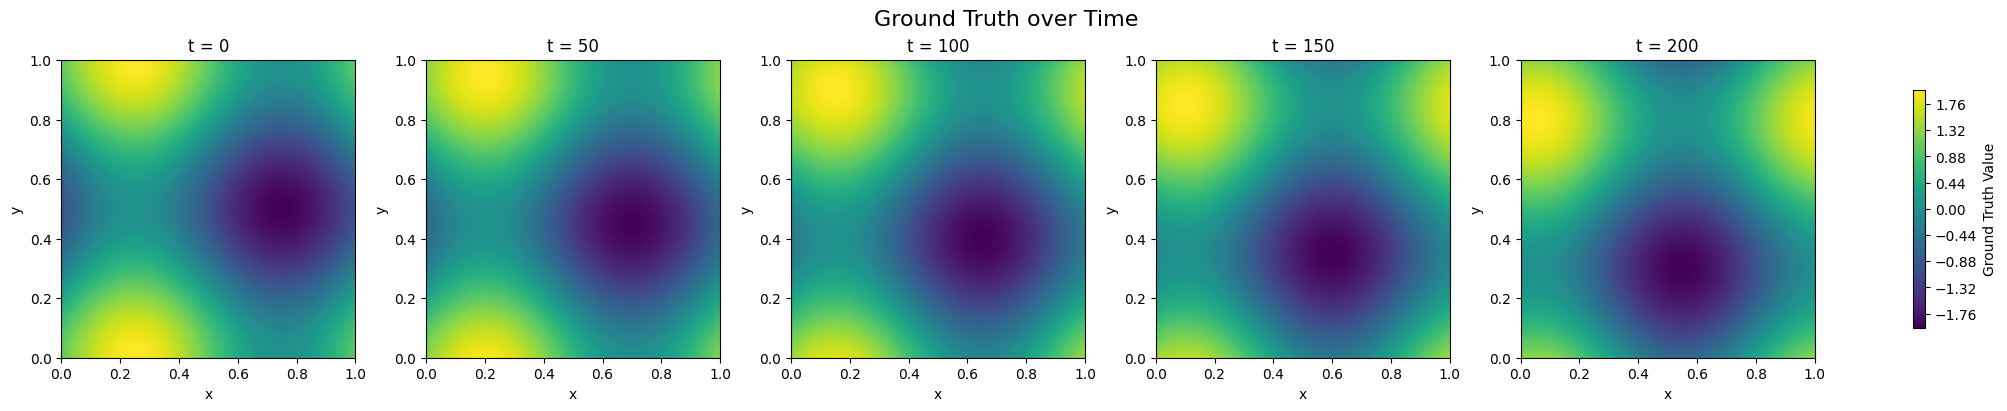

In [2]:
SEED = 0

n = 10
omega = 2*np.pi/1
v = 2*np.pi/1000

# TODO: markdown cell that allows to tune E and sigma_w

drones = [
    Agent(
    s=2,
    E=100,
    k=ConstantKernel(1e-2, constant_value_bounds="fixed") * RBF(10, length_scale_bounds="fixed"),
    sigma_v=1e-3,
    sigma_w=1e-5,
    n=n,
    init_pos=np.random.uniform(low=0.0, high=1.0, size=(2)),
    seed=SEED) for _ in range(n)
]

ground_truth = lambda pos, t: np.sin(omega*pos[0] + v*t) + np.cos(omega*pos[1] + v*t)

# Create 50x50 grid over [0,1] x [0,1]
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)
t_values = [0, 50, 100, 150, 200]

# Create subplots: 1 row, 5 columns
fig, axes = plt.subplots(1, len(t_values), figsize=(20, 4), constrained_layout=True)

for ax, t in zip(axes, t_values):
    Z = ground_truth((X, Y), t)
    contour = ax.contourf(X, Y, Z, levels=100)
    ax.set_title(f"t = {t}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

# Add one colorbar for all subplots
fig.colorbar(contour, ax=axes.ravel().tolist(), shrink=0.8, label="Ground Truth Value")

plt.suptitle("Ground Truth over Time", fontsize=16)
plt.show()


In [3]:
# Simulate num_step steps of the simulation
np.random.seed(SEED)
num_steps=100
d = 0.2
for step in range(num_steps):
    # Each drone moves according to a random walk with steps sampled
    # from a Gaussian with average 0 and standard deviation 0.5,
    # clipped in order to stay in the domain
    for drone in drones:
        delta_pos = np.random.normal(loc=0.0, scale=0.5, size=(2))
        new_pos = np.clip(drone.pos + delta_pos, a_min=0, a_max=1)
        drone.update_pos(new_pos)

    for drone in drones:
        # Measurement
        y = ground_truth(drone.pos, num_steps)
        
        # Local update through Kalman Filter
        drone.local_update(drone.pos, y)

    for substep in range(SensingPeriod):
        # Newtork update
        for drone in drones:
            # Compute neighbours set (drones at a maximum distance d)
            neighbours = []
            for drone2 in drones:
                if np.norm(drone.pos - drone2.pos) < d:
                    neighbours.append(drone2)

            # Network update for the drone
            drone.network_update(neighbours)

    # TODO: plot here the network on the ground truth, with drone i drawn bigger and the estimate of drone i

    

ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)